## Import data

Tyrosine Kinases ligands with bioactivity data, by Ricardo Romero Ochoa on kaggle
Small compounds targeting tyrosine kinases, curated from the ChEMBL database
28314 small compounds

Ricardo Romero Ochoa. (2024). Tyrosine Kinases ligands with bioactivity data [Data set]. Kaggle. https://doi.org/10.34740/KAGGLE/DSV/8626441

The data can be used to train models that predict or classify bioactivity and druglike properties of small compounds targeting a tyrosine kinase protein.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

drugs_dataset = pd.read_csv("./kinase_data_final_tox.csv")

In [ ]:
# Get a sense of the data
drugs_dataset

,molecule_chembl_id,canonical_smiles,IC50,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50,target,Druglikeness,Mutagenic,Tumorigenic,Reproductive Effective,Irritant
0,CHEMBL4557543,COc1cc(OC)c(Cl)c(-c2ccc3c(NC(=O)c4ccc(N5CCN(C)...,14.00,active,575.884,5.60640,2,7,7.853872,FGFR,8.89410,none,high,high,none
1,CHEMBL3904778,C=CC(=O)Nc1cccc(Oc2nc(Nc3ccc(OC)cc3OC)ncc2Br)c1,65.00,active,471.311,4.91670,2,7,7.187087,EGFR,-10.11200,high,low,low,low
2,CHEMBL1087421,COc1cc2c(cc1Cl)C(c1ccc(Cl)c(Cl)c1)=NCC2,10000.00,inactive,340.637,5.04890,0,2,5.000000,EGFR,0.70500,none,none,none,none
3,CHEMBL604712,CC(C)(C)C(=O)N1Cc2c(NC(=O)c3cc(F)cc(F)c3)n[nH]...,10000.00,inactive,376.407,3.56360,2,3,5.000000,ABL,1.01070,none,none,none,none
4,CHEMBL556684,COc1cc(O)c2c(c1)C(=O)c1cc(C)c(O)c(O)c1C2=O,4.00,active,300.266,1.89582,3,6,8.397940,EGFR,-0.97635,low,none,none,high
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28309,CHEMBL1822773,COc1ccc(CCC(=O)N/N=C2\C(=O)Nc3c(Cl)ccc(Cl)c32)cc1,2000.00,intermediate,392.242,3.40720,2,4,5.698970,MET,4.21000,none,high,high,low
28310,CHEMBL366580,Brc1cccc(Nc2ncnc3cc4c[nH]nc4cc23)c1,0.34,active,340.184,4.01220,2,4,9.468521,EGFR,1.30470,high,none,none,none
28311,CHEMBL2408503,O=C(COc1cc(O)c2c(=O)cc(-c3ccccc3)oc2c1)Nc1cccc...,17600.00,inactive,466.287,4.94560,2,5,4.754487,ABL,0.33822,none,none,none,none
28312,CHEMBL1725279,Oc1c2ccccc2c2c3c(cccc13)N=N2,957.00,active,220.231,4.42740,1,3,6.019088,JAK,-5.87440,high,high,none,high


but the loaded dataset contains 21441 compounds

## About the dataset
- molecule_chembl_id: Identifier for the compound
- canonical_smiles: Simplified Molecular Input Line Entry System, used to describe molecular structure.
- IC50: concentration of a drug required to reduce the biological process by 50%
- class: Inactive (IC50 >= 10 000 nm); Active (IC50 =< 1000 nm); Intermediate (1000 < IC50 < 10 000 nm)
(IC50 > 10^9 nM) were converted to 1
- MW: molecular weight
- LogP: Water-octanol partition coefficient. Indicative of a compound's hydrophobicity/lipophilicity. logarithm of the ratio of a compound's concentration in octanol to its concentration in water. Greater logP means more lipophilic & non-polar compound.
- NumHDonors: Number of Hydrogen bond donors
- NumHAcceptors: Number of Hydrogen bond acceptors
- pIC50: -log10(IC50); larger pIC50 means more effective drug
- target: the tyrosine kinase(s) targeted by the compound
- Druglikeness: similarity of properties between the compound and existing drugs
- Mutagenic, Tumorigenic, Reproductive Effective, Irritant


In [4]:
import seaborn as sns

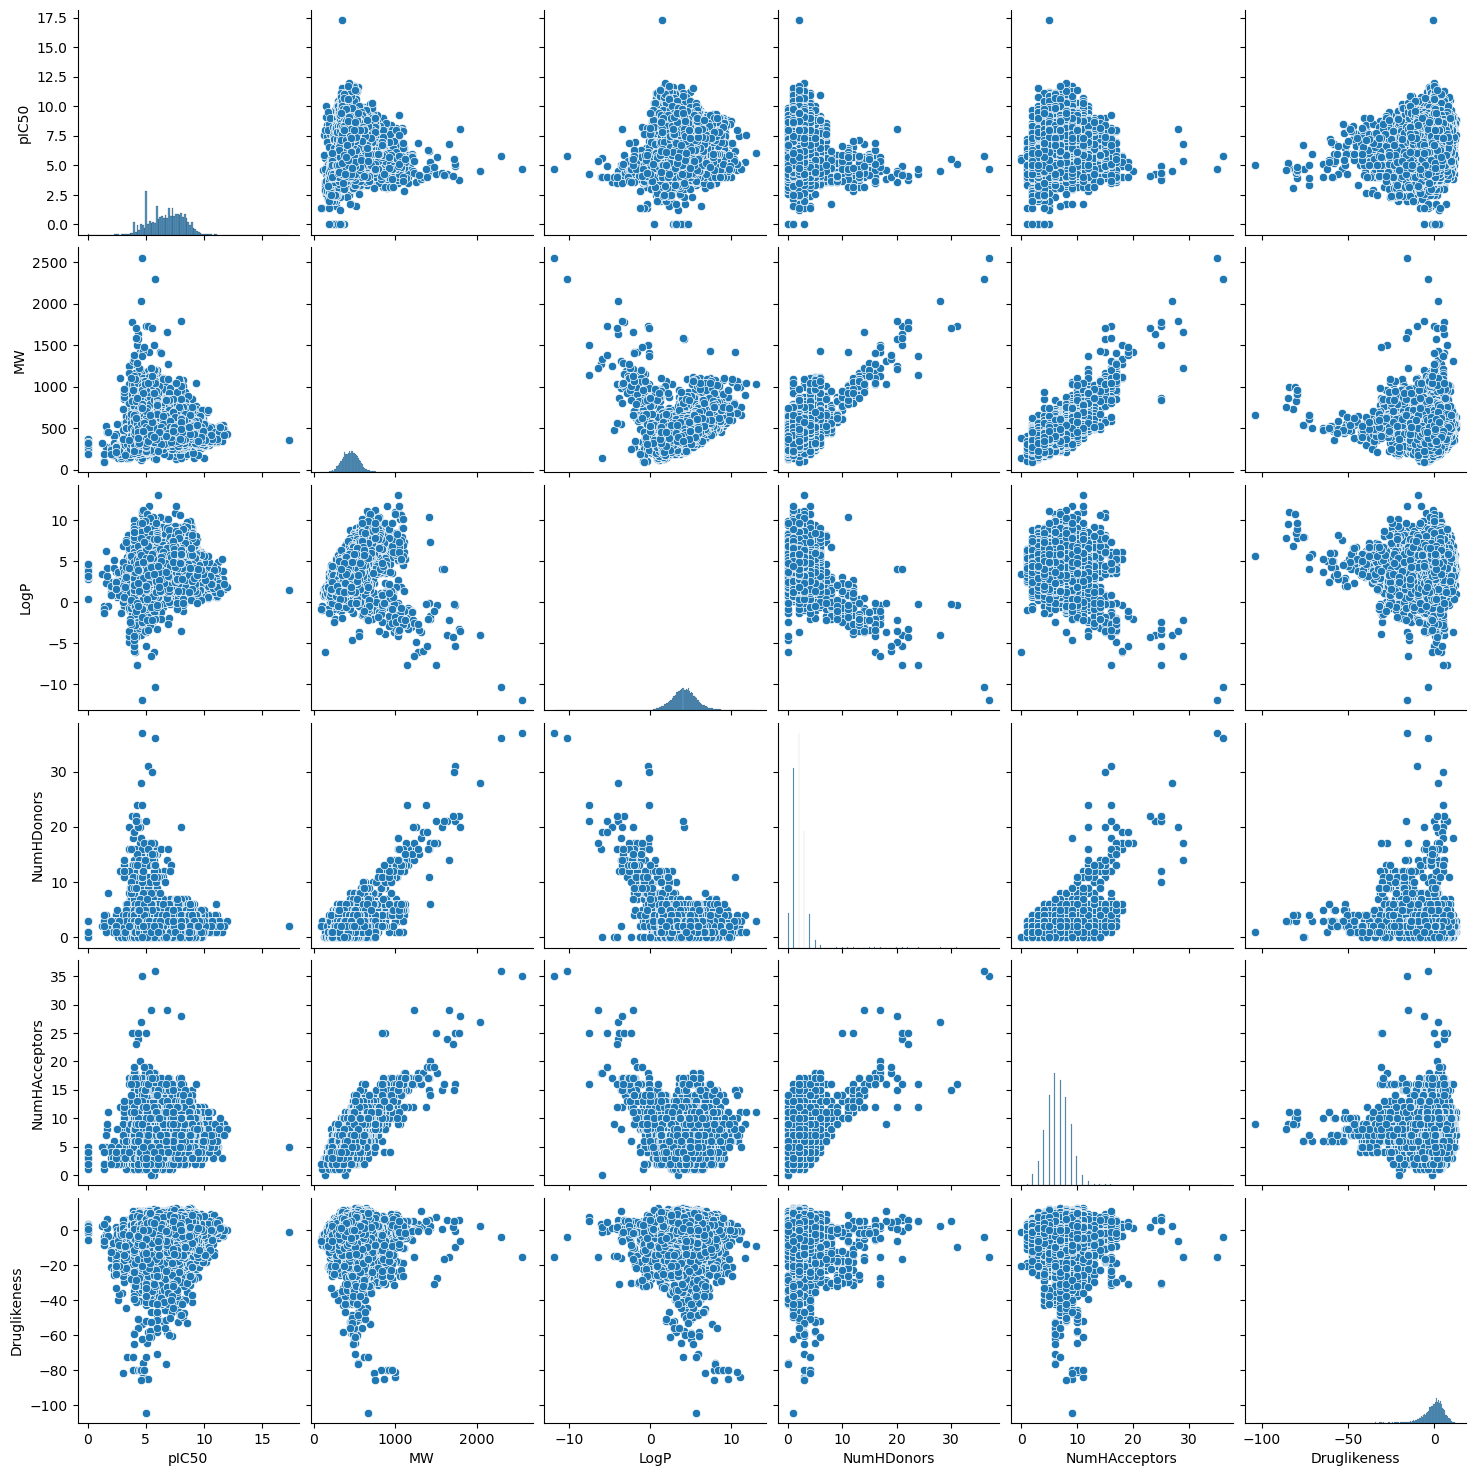

In [9]:
subset = drugs_dataset[["pIC50", "MW", "LogP", "NumHDonors", "NumHAcceptors", "Druglikeness"]]
sns.pairplot(subset)

## Aims & goals

Aim: train a model to predict how well a given compound targets receptor tyrosine kinases.

Strategy A: 
- Input: chemical structure of the compound
- Label/Output: class (inactive, intermediate, active)

Strategy B:
- Input: chemical structure of the compound
- Output: IC50 value

Strategy A is a classification problem, and we will attempt solving it with neural nets.

Other possible questions one could address with this dataset
- What is the compound's mutagenicity? none/low/high
- What is the compound's tumorigenecity?
- What is the compound's reproductive toxicity?
- What is the compound's irritation level?
- etc.

## Data preprocessing

To convert the chemical structures into more appropriate inputs for the neural network, we will generate molecular fingerprints for each compound. We do so by applying a kernel to a molecule, whcih generates a bit or count vector. This is done using the package RDKit.
https://www.rdkit.org/UGM/2012/Landrum_RDKit_UGM.Fingerprints.Final.pptx.pdf

In [14]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem

In [15]:
# Convert the canonical_smiles strings to RDKit molecules
compounds = [Chem.MolFromSmiles(smiles) for smiles 
             in drugs_dataset['canonical_smiles']]

# Generate the Morgan fingerprints for each molecule
fingerprints = [Chem.RDKFingerprint(compound) for compound in compounds]

In [ ]:
# Standarise input
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
fingerprints_scaled = scaler.fit_transform(fingerprints) 

In [ ]:
# View & save scaled fingerprints, since scaling takes time
print(fingerprints_scaled[:5])
np.save('./fingerprints_scaled.npy', fingerprints_scaled)

[[ 0.23991246  0.7671586  -1.12784173 ... -0.77350276  1.00007064
   0.3246043 ]
 [ 0.23991246 -1.30351143  0.88664923 ... -0.77350276  1.00007064
   0.3246043 ]
 [ 0.23991246  0.7671586   0.88664923 ... -0.77350276 -0.99992937
   0.3246043 ]
 [ 0.23991246  0.7671586  -1.12784173 ...  1.29282021 -0.99992937
   0.3246043 ]
 [ 0.23991246  0.7671586  -1.12784173 ...  1.29282021 -0.99992937
  -3.08067396]]


In [ ]:
# Sanity check everything saved appropriately
arr_loaded = np.load('./fingerprints_scaled.npy')
np.array_equal(arr_loaded, fingerprints_scaled)

True

## Architecture 1:

### Important parameters: 

- Learning rate: 
- Learning rate method: https://keras.io/api/optimizers/ 
- Activation function: linear, sigmoid, relu, softmax, tanh. Last layer will use softmax to determine which class is most likely

- Number of layers
- Number of nodes per layer
- epochs
- batch_size
- Loss function: sparse_categorical_crossentropy (integer labels). https://keras.io/api/losses/ 
- Preventing overfitting: L1 or L2 regularisation

### Performance measures
- Correlation: not appropriate since we are predicting categorical variables based on non-numerical input
- PPV: Positive Predictive Value: No. of true positives/No. of true positives + No. of false positives
- F1: 2TP/(2TP + FP + FN)
- ROS: False positive vs. True positive; AUC: Area under the ROC curve 


Cross-validation: 20% test data, 60% training data, 20% validation data. 
k-fold cross validation: we will make 4 rounds of training-validation data



Optimise using Optuna?


In [31]:
train_x = fingerprints_scaled
train_y = drugs_dataset[["class"]]

## Tutorial architecture

In [35]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, cross_val_score

In [36]:
# Train the neural network model
model = MLPClassifier(hidden_layer_sizes=(100, 50, 25), activation='relu', alpha=0.001, solver='adam',
                      learning_rate='constant', max_iter=200, batch_size='auto', learning_rate_init=0.001,
                      shuffle=True, random_state=42, tol=1e-4, verbose=True, warm_start=False,
                      early_stopping=True, validation_fraction=0.1, n_iter_no_change=10)

In [ ]:
# Perform cross-validation and get the scores
cv_scores = cross_val_score(model, fingerprints_scaled, train_y, cv=5)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Average cross-validation score:", np.mean(cv_scores))

In [ ]:
# Splits the data into training and testing sets (80/20 ratio)
X_train, X_test, y_train, y_test = train_test_split(fingerprints, 
                                            labels, test_size=0.2, random_state=42)
# Train the model on the training set
model.fit(X_train, y_train)

In [ ]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
# Calculate the ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

In [ ]:
# Plot the ROC curve
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

## My model 1

In [64]:
train_x = fingerprints_scaled
train_y = drugs_dataset[["class"]]

In [81]:
from tensorflow.keras.layers import Input
import keras
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical


In [ ]:
batch_size = 32
num_classes = 3
epochs = 20

In [72]:
train_x.shape[1:]

(2048,)

In [82]:
# Step 1: Encode the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(train_y)  # e.g., 'active' -> 0, 'inactive' -> 1, etc.
y_one_hot = to_categorical(y_encoded)

/Users/inikaprasad/miniforge3/envs/python-x64/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [83]:
y_one_hot

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [84]:
model = Sequential()
model.add(Input(shape=train_x.shape[1:]))

model.add(Dense(10, activation='tanh'))

model.add(Dense(num_classes, activation = 'softmax'))


In [63]:
opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)


In [85]:
# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 10)                20490     
_________________________________________________________________
dense_16 (Dense)             (None, 3)                 33        
Total params: 20,523
Trainable params: 20,523
Non-trainable params: 0
_________________________________________________________________


In [86]:
hist = model.fit(train_x, y_one_hot, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
708/708 [==============================] - 2s 2ms/step - loss: 1.0515 - accuracy: 0.5120 - val_loss: 0.7517 - val_accuracy: 0.7012
Epoch 2/10
708/708 [==============================] - 1s 1ms/step - loss: 0.6932 - accuracy: 0.7328 - val_loss: 0.6444 - val_accuracy: 0.7475
Epoch 3/10
708/708 [==============================] - 1s 1ms/step - loss: 0.5924 - accuracy: 0.7705 - val_loss: 0.5958 - val_accuracy: 0.7685
Epoch 4/10
708/708 [==============================] - 1s 1ms/step - loss: 0.5451 - accuracy: 0.7926 - val_loss: 0.5703 - val_accuracy: 0.7759
Epoch 5/10
708/708 [==============================] - 1s 1ms/step - loss: 0.5084 - accuracy: 0.8076 - val_loss: 0.5534 - val_accuracy: 0.7833
Epoch 6/10
708/708 [==============================] - 1s 1ms/step - loss: 0.4871 - accuracy: 0.8164 - val_loss: 0.5434 - val_accuracy: 0.7881
Epoch 7/10
708/708 [==============================] - 1s 1ms/step - loss: 0.4648 - accuracy: 0.8244 - val_loss: 0.5302 - val_accuracy: 0.7883
Epoch 

In [ ]:
from keras.utils import plot_model

plot_model(model, "figures/simplenet_model.png", show_shapes=True)

## Architecture 2:

## Conclusions
Which ML method?
Performance
Sensitivity to parameter choices
Ease of use